In [11]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import  metrics
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
%matplotlib inline

In [12]:
df = pd.read_csv("dataset/tensor.csv",header=None)
df = df.dropna()

In [13]:
df.shape

(4208, 1825)

In [14]:
X = df.drop([1824],axis=1)
Y = df[1824]

In [15]:
X, X_test, Y , y_test = train_test_split(  X, Y, test_size=0.33, random_state=42)

In [16]:
X.shape

(2819, 1824)

In [18]:
X_test.shape

(1389, 1824)

In [6]:
classifier =  GradientBoostingClassifier(random_state=10)


In [7]:
classifier.fit(X, Y)  # 训练数据来学习，不需要返回值


GradientBoostingClassifier(random_state=10)

In [8]:
count = 0
for index , row in X_test.iterrows():
    if ((classifier.predict([row]) == y_test[index])):
        count += 1

In [9]:
count/4221


0.28760957119166075

In [10]:
count / (4221*0.33)

0.8715441551262446

In [ ]:

     

from sklearn.metrics import roc_auc_score
import gc
import warnings
warnings.filterwarnings("ignore")

skt=StratifiedKFold(5,shuffle=True)

splits = skt.split(X, y)
score_train = []
score_valid = []
clfs=[]
X=pd.DataFrame(X)
y=pd.DataFrame(y)
for fold_n, (train_index, valid_index) in enumerate(splits):
    X_train, X_valid = X.iloc[train_index].values, X.iloc[valid_index].values
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]


    clf = clf=gbdt_lr(gbdt=lgb.LGBMClassifier,gbdt_params={'n_estimators':500},lr=LogisticRegression,lr_params={'C':1.0})

    clf.fit(X_train,y_train)

    y_pred_train = clf.predict_proba(X_train)[:,1]
    y_pred_valid = clf.predict_proba(X_valid)[:,1]

    score_train.append(roc_auc_score(y_train,y_pred_train))
    score_valid.append(roc_auc_score(y_valid, y_pred_valid))

    del X_train, X_valid, y_train, y_valid

    gc.collect()

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator,ClassifierMixin


class gbdt_lr(BaseEstimator, ClassifierMixin):

    def __init__(self, gbdt=None, lr=None,gbdt_params=None,lr_params=None,cv=CountVectorizer(analyzer='word',preprocessor=None,ngram_range=(1,1),stop_words=None,min_df=0,)):
        self.gbdt=gbdt(**gbdt_params)
        self.lr=lr(**lr_params)
        self.cv=cv
    def fit(self, X, y):
        self.gbdt.fit(X,y)
        leaf = (self.gbdt.predict(X, pred_leaf=True)).astype(str).tolist()

        leaf=[' '.join(item) for item in leaf]
        self.result=self.cv.fit_transform(leaf)
        X= self.lr.fit(self.result,y)
        return self
    
    def predict_proba(self, X):
        leaf=self.gbdt.predict(X, pred_leaf=True)
        leaf = (self.gbdt.predict(X, pred_leaf=True)).astype(str).tolist()
        leaf=[' '.join(item) for item in leaf]
        result=self.cv.transform(leaf)
        
        return self.lr.predict_proba(result)

[0.98781568 0.04626204 0.98781568 ... 0.94571782 0.98781568 0.430834  ]


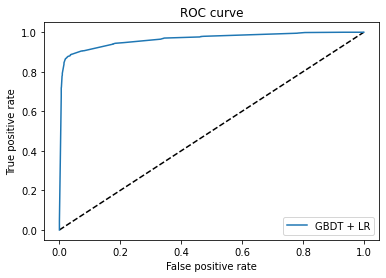

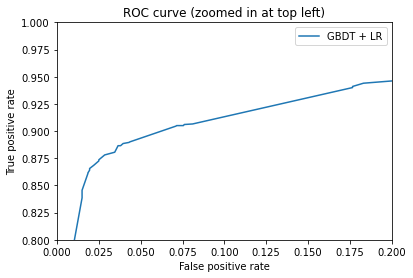

In [4]:
import numpy as np
np.random.seed(10)
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve


n_estimator = 10
X, y = make_classification(n_samples=8000)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

# 将训练集切分为两部分，一部分用于训练GBDT模型，另一部分输入到训练好的GBDT模型生成GBDT特征，然后作为LR的特征。这样分成两部分是为了防止过拟合。
X_train, X_train_lr, y_train, y_train_lr = train_test_split(
    X_train, y_train, test_size=0.5)

#print(X_train.shape)  (20000, 20)
#print(y_train.shape) (20000,)

gbdt = GradientBoostingClassifier(n_estimators=n_estimator)

"""
n_estimators,最大的弱学习器的个数，即有多少个回归树
max_depth : int, default=3。每个回归树的的深度
"""


gbdt_enc = OneHotEncoder()
lr = LogisticRegression(max_iter=1000)




gbdt.fit(X_train, y_train) # 训练GBDT模型

gbdt_enc.fit(gbdt.apply(X_train)[:, :, 0]) # one-hot编码,shape=(20000, 80)
# model.apply(X_train)返回训练数据X_train在训练好的模型里每棵树中所处的叶子节点的位置（索引）
lr.fit(gbdt_enc.transform(gbdt.apply(X_train_lr)[:, :, 0]), y_train_lr) # 训练LR模型

y_pred_gbdt_lr = lr.predict_proba(
    gbdt_enc.transform(gbdt.apply(X_test)[:, :, 0]))[:, 1]
print(y_pred_gbdt_lr)
fpr_grd_lr, tpr_grd_lr, _ = roc_curve(y_test, y_pred_gbdt_lr)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr_grd_lr, tpr_grd_lr, label='GBDT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')

plt.plot(fpr_grd_lr, tpr_grd_lr, label='GBDT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()

In [6]:
X.shape

(8000, 20)

In [9]:
y.shape

(8000,)